- Green taxi trips and Yellow taxi trips
- Time period: January 1-31, 2025

**Research Questions:**
1. How do trip volumes vary by time of day and day of week?
2. What are the peak vs off-peak travel patterns?
3. How do green and yellow taxis differ in their service areas?
4. How do fare patterns differ between taxi types and time periods?

---

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
data_dir = Path('data')  # Points to the data directory
df1 = pd.read_parquet('data/green_tripdata_2025-01.parquet')
df2 = pd.read_parquet('data/yellow_tripdata_2025-01.parquet')

In [3]:
def show_stats(df):
    print(f"Shape: {df.shape}")
    print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
    
    if 'PULocationID' in df.columns:
        pu_min, pu_max = df['PULocationID'].min(), df['PULocationID'].max()
        do_min, do_max = df['DOLocationID'].min(), df['DOLocationID'].max()
        print(f"PULocationID range: [{pu_min}, {pu_max}]")
        print(f"DOLocationID range: [{do_min}, {do_max}]")
    
    if 'PU_Zone' in df.columns:
        pu_nulls = df['PU_Zone'].isnull().sum()
        do_nulls = df['DO_Zone'].isnull().sum()
        print(f"PU_Zone nulls: {pu_nulls} | DO_Zone nulls: {do_nulls}")
        print(f"Unique PU zones: {df['PU_Zone'].nunique()} | Unique DO zones: {df['DO_Zone'].nunique()}")
    
    display(df.head(3))

In [4]:
zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')

In [5]:
# Check for any missing or null values in zone lookup
print(zone_lookup[zone_lookup['Zone'].isnull() | zone_lookup['Borough'].isnull()])

     LocationID  Borough            Zone service_zone
263         264  Unknown             NaN          NaN
264         265      NaN  Outside of NYC          NaN


In [6]:
# Fix missing Zone and Borough values
zone_lookup.loc[zone_lookup['Zone'].isnull(), 'Zone'] = 'Unknown'
zone_lookup.loc[zone_lookup['Borough'].isnull(), 'Borough'] = 'Unknown'

In [7]:
# Check for any missing or null values in zone lookup after fixing the data
print(zone_lookup[zone_lookup['Zone'].isnull() | zone_lookup['Borough'].isnull()])

Empty DataFrame
Columns: [LocationID, Borough, Zone, service_zone]
Index: []


#### Zone Coverage

In [8]:
print("GREEN TAXI BEFORE MERGE")
show_stats(df1)
print("\nYELLOW TAXI BEFORE MERGE")
show_stats(df2)

GREEN TAXI BEFORE MERGE
Shape: (48326, 21)
Rows: 48,326 | Columns: 21
PULocationID range: [3, 265]
DOLocationID range: [1, 265]


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,1.0,0.5,6.8,0.0,NaN,1.0,34.00,1.0,1.0,0.0,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,1.0,0.5,0.0,0.0,NaN,1.0,11.10,2.0,1.0,0.0,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,0.0,0.0,0.0,0.0,NaN,1.0,26.55,2.0,2.0,0.0,0.0



YELLOW TAXI BEFORE MERGE
Shape: (3475226, 20)
Rows: 3,475,226 | Columns: 20
PULocationID range: [1, 265]
DOLocationID range: [1, 265]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.6,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.5,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.6,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0


In [ ]:
# Merge zone names with taxi data, so the pickup and dropoff location ids can be effectively mapped to names
for prefix, id_col in [('PU', 'PULocationID'), ('DO', 'DOLocationID')]:
    df1 = df1.merge(zone_lookup[['LocationID', 'Borough', 'Zone']], 
                    left_on=id_col, right_on='LocationID', how='left') \
             .rename(columns={'Borough': f'{prefix}_Borough', 'Zone': f'{prefix}_Zone'}) \
             .drop('LocationID', axis=1)
    
    df2 = df2.merge(zone_lookup[['LocationID', 'Borough', 'Zone']], 
                    left_on=id_col, right_on='LocationID', how='left') \
             .rename(columns={'Borough': f'{prefix}_Borough', 'Zone': f'{prefix}_Zone'}) \
             .drop('LocationID', axis=1)

In [10]:
print("GREEN TAXI AFTER MERGE")
show_stats(df1)
print("\nYELLOW TAXI AFTER MERGE")
show_stats(df2)

GREEN TAXI AFTER MERGE
Shape: (48326, 25)
Rows: 48,326 | Columns: 25
PULocationID range: [3, 265]
DOLocationID range: [1, 265]
PU_Zone nulls: 0 | DO_Zone nulls: 0
Unique PU zones: 211 | Unique DO zones: 240


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,PU_Borough,PU_Zone,DO_Borough,DO_Zone
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,1.0,0.5,6.8,0.0,NaN,1.0,34.00,1.0,1.0,0.0,0.0,Manhattan,East Harlem South,Bronx,University Heights/Morris Heights
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,1.0,0.5,0.0,0.0,NaN,1.0,11.10,2.0,1.0,0.0,0.0,Manhattan,Morningside Heights,Manhattan,East Harlem South
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,0.0,0.0,0.0,0.0,NaN,1.0,26.55,2.0,2.0,0.0,0.0,Queens,Murray Hill-Queens,Queens,East Flushing



YELLOW TAXI AFTER MERGE
Shape: (3475226, 24)
Rows: 3,475,226 | Columns: 24
PULocationID range: [1, 265]
DOLocationID range: [1, 265]
PU_Zone nulls: 0 | DO_Zone nulls: 0
Unique PU zones: 260 | Unique DO zones: 259


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,PU_Borough,PU_Zone,DO_Borough,DO_Zone
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.6,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0,Manhattan,Sutton Place/Turtle Bay North,Manhattan,Upper East Side South
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.5,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,Manhattan,Upper East Side North,Manhattan,Upper East Side South
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.6,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0,Manhattan,Lenox Hill West,Manhattan,Lenox Hill West


##### Temporal Analysis: Trip Volume Patterns
Analyzing trip volumes by hour of day, day of week, and identifying peak vs off-peak patterns.

In [11]:
def prepare_temporal_data(df, taxi_type):
    df = df.copy()
    datetime_col = 'lpep_pickup_datetime' if taxi_type == 'green' else 'tpep_pickup_datetime'
    df['pickup_datetime'] = pd.to_datetime(df[datetime_col])
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.day_name()
    df['date'] = df['pickup_datetime'].dt.date
    return df

df1_temporal = prepare_temporal_data(df1, 'green')
df2_temporal = prepare_temporal_data(df2, 'yellow')

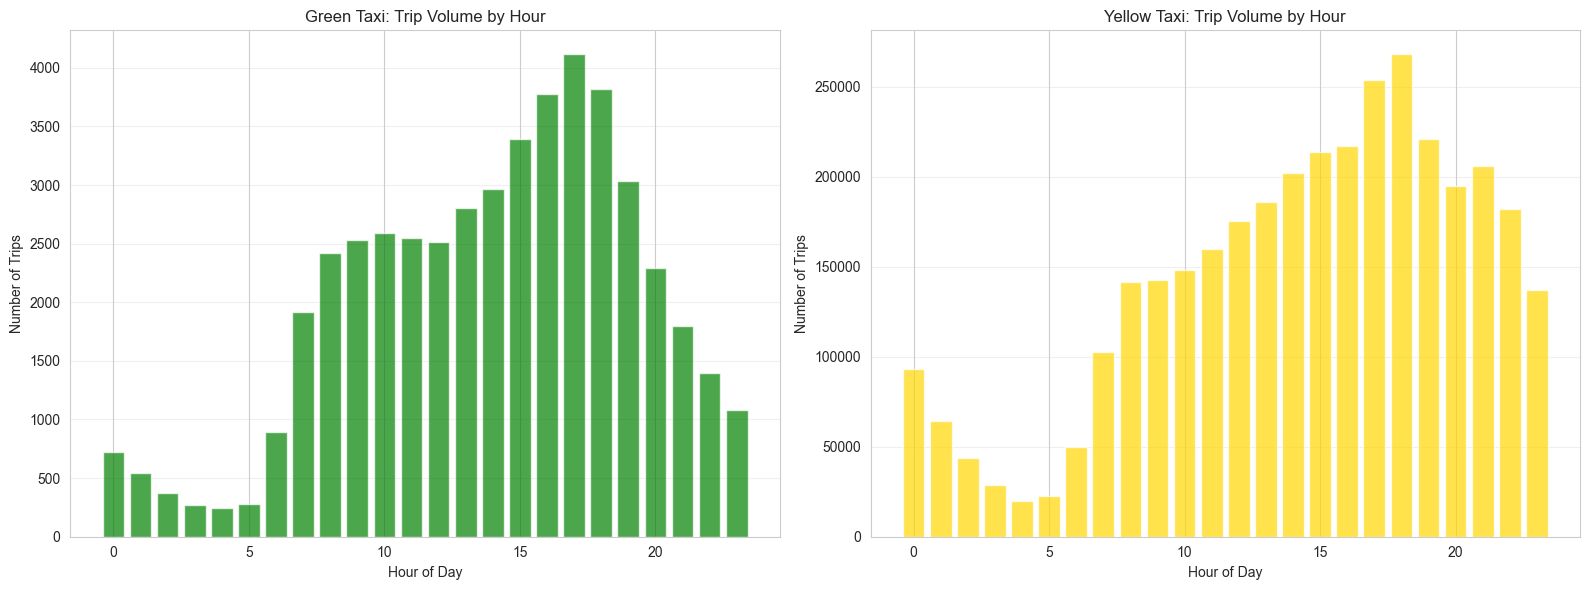

In [12]:
# Trip volume by hour of day
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Green taxi
hourly_green = df1_temporal.groupby('hour').size()
axes[0].bar(hourly_green.index, hourly_green.values, color='green', alpha=0.7)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Trips')
axes[0].set_title('Green Taxi: Trip Volume by Hour')
axes[0].grid(axis='y', alpha=0.3)

# Yellow taxi
hourly_yellow = df2_temporal.groupby('hour').size()
axes[1].bar(hourly_yellow.index, hourly_yellow.values, color='gold', alpha=0.7)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Trips')
axes[1].set_title('Yellow Taxi: Trip Volume by Hour')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

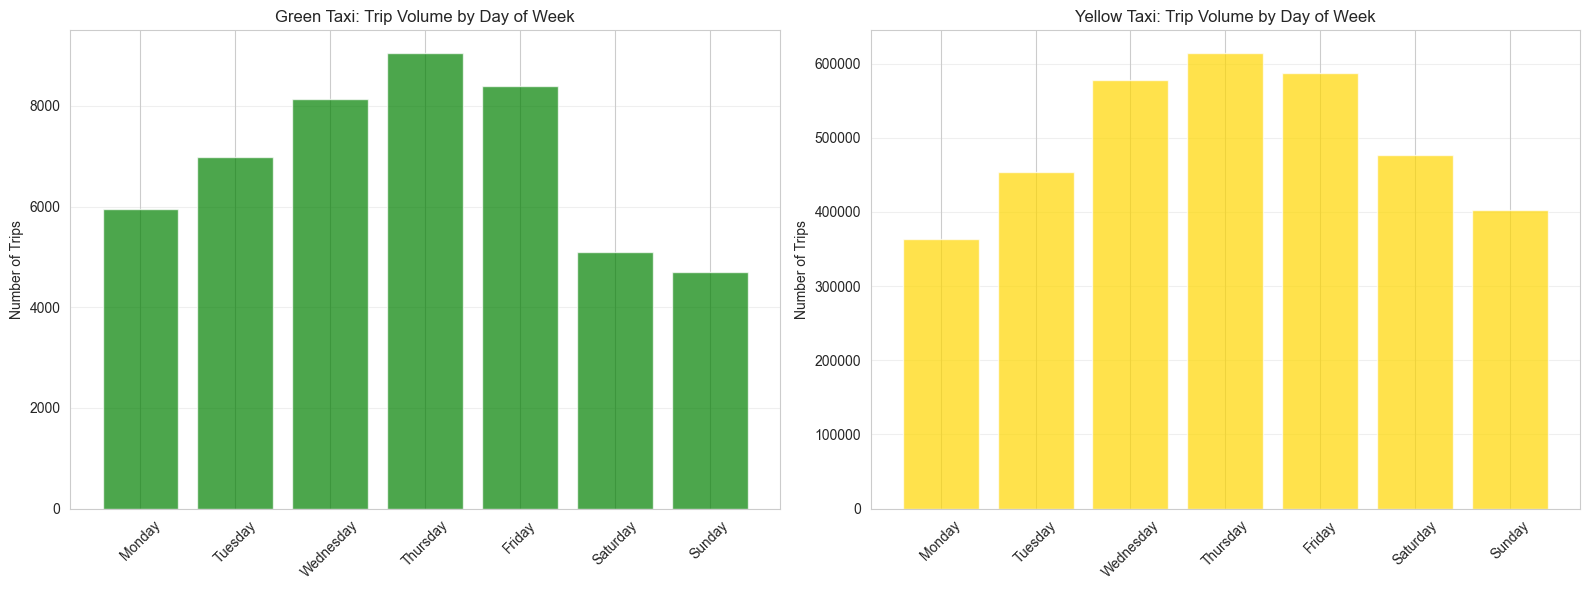

In [13]:
# Trip volume by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Green taxi
daily_green = df1_temporal.groupby('day_of_week').size().reindex(day_order)
axes[0].bar(range(len(day_order)), daily_green.values, color='green', alpha=0.7)
axes[0].set_xticks(range(len(day_order)))
axes[0].set_xticklabels(day_order, rotation=45)
axes[0].set_ylabel('Number of Trips')
axes[0].set_title('Green Taxi: Trip Volume by Day of Week')
axes[0].grid(axis='y', alpha=0.3)

# Yellow taxi
daily_yellow = df2_temporal.groupby('day_of_week').size().reindex(day_order)
axes[1].bar(range(len(day_order)), daily_yellow.values, color='gold', alpha=0.7)
axes[1].set_xticks(range(len(day_order)))
axes[1].set_xticklabels(day_order, rotation=45)
axes[1].set_ylabel('Number of Trips')
axes[1].set_title('Yellow Taxi: Trip Volume by Day of Week')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

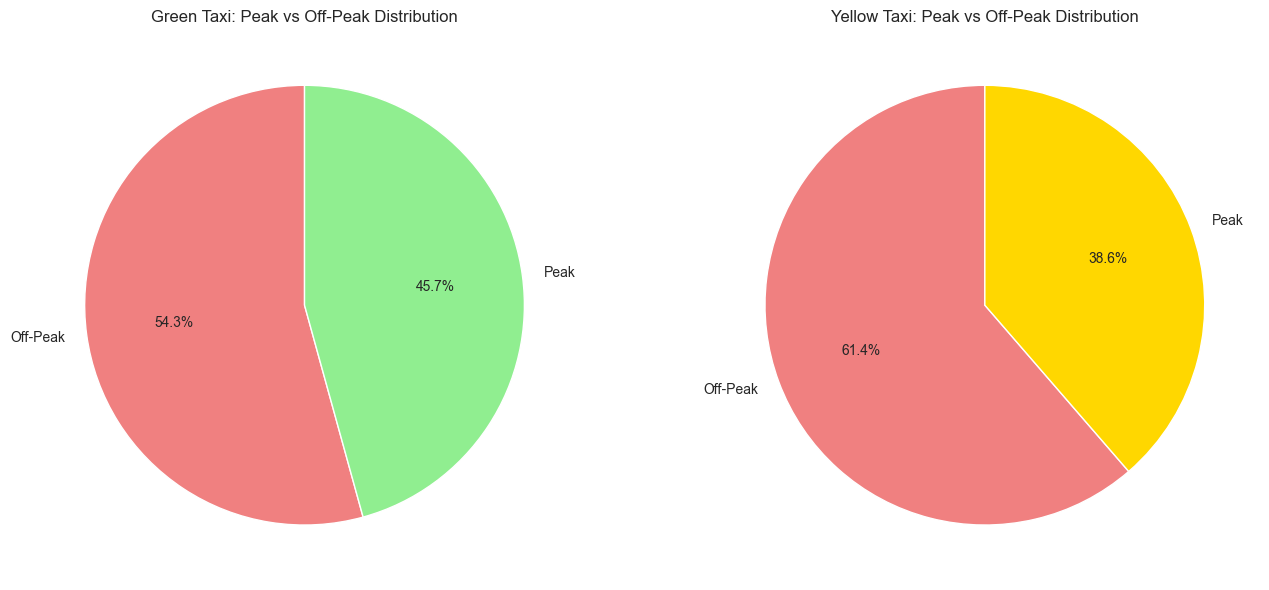

In [14]:
# Peak vs Off-Peak analysis (Peak: 7-10 AM and 4-8 PM on weekdays)
def classify_peak(row):
    hour = row['hour']
    day = row['day_of_week']
    is_weekday = day not in ['Saturday', 'Sunday']
    
    # Classification of peak hours
    # Weekday and 7am - 10am, 4pm - 8pm
    if is_weekday and ((7 <= hour <= 10) or (16 <= hour <= 20)):
        return 'Peak'
    else:
        return 'Off-Peak'

df1_temporal['period'] = df1_temporal.apply(classify_peak, axis=1)
df2_temporal['period'] = df2_temporal.apply(classify_peak, axis=1)

# Visualize peak vs off-peak
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

peak_green = df1_temporal['period'].value_counts()
axes[0].pie(peak_green.values, labels=peak_green.index, autopct='%1.1f%%', 
            colors=['lightcoral', 'lightgreen'], startangle=90)
axes[0].set_title('Green Taxi: Peak vs Off-Peak Distribution')

peak_yellow = df2_temporal['period'].value_counts()
axes[1].pie(peak_yellow.values, labels=peak_yellow.index, autopct='%1.1f%%', 
            colors=['lightcoral', 'gold'], startangle=90)
axes[1].set_title('Yellow Taxi: Peak vs Off-Peak Distribution')

plt.tight_layout()
plt.show()

#### Destination Analysis: Green vs Yellow Taxi
Comparing pickup and dropoff locations between green and yellow taxis.

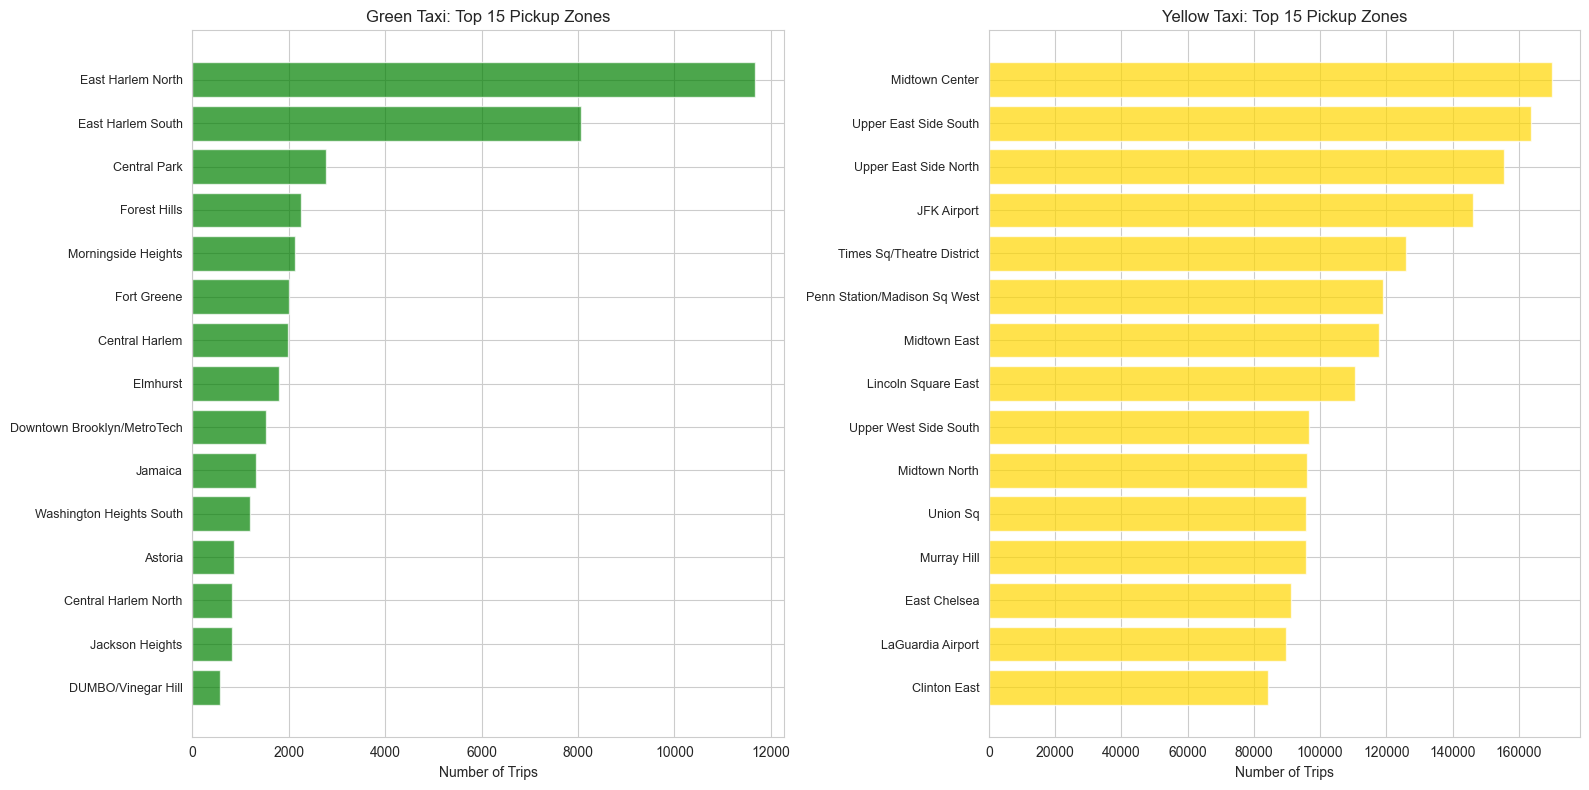

In [107]:
# Visualize top pickup locations with zone names
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Green taxi top pickups
top_pickup_green = df1['PU_Zone'].value_counts().head(15)
axes[0].barh(range(len(top_pickup_green)), top_pickup_green.values, color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_pickup_green)))
axes[0].set_yticklabels(top_pickup_green.index, fontsize=9)
axes[0].set_xlabel('Number of Trips')
axes[0].set_title('Green Taxi: Top 15 Pickup Zones')
axes[0].invert_yaxis()

# Yellow taxi top pickups
top_pickup_yellow = df2['PU_Zone'].value_counts().head(15)
axes[1].barh(range(len(top_pickup_yellow)), top_pickup_yellow.values, color='gold', alpha=0.7)
axes[1].set_yticks(range(len(top_pickup_yellow)))
axes[1].set_yticklabels(top_pickup_yellow.index, fontsize=9)
axes[1].set_xlabel('Number of Trips')
axes[1].set_title('Yellow Taxi: Top 15 Pickup Zones')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

#### Fare Distribution and Statistics
Analyzing fare patterns with statistical summaries and visualizations.

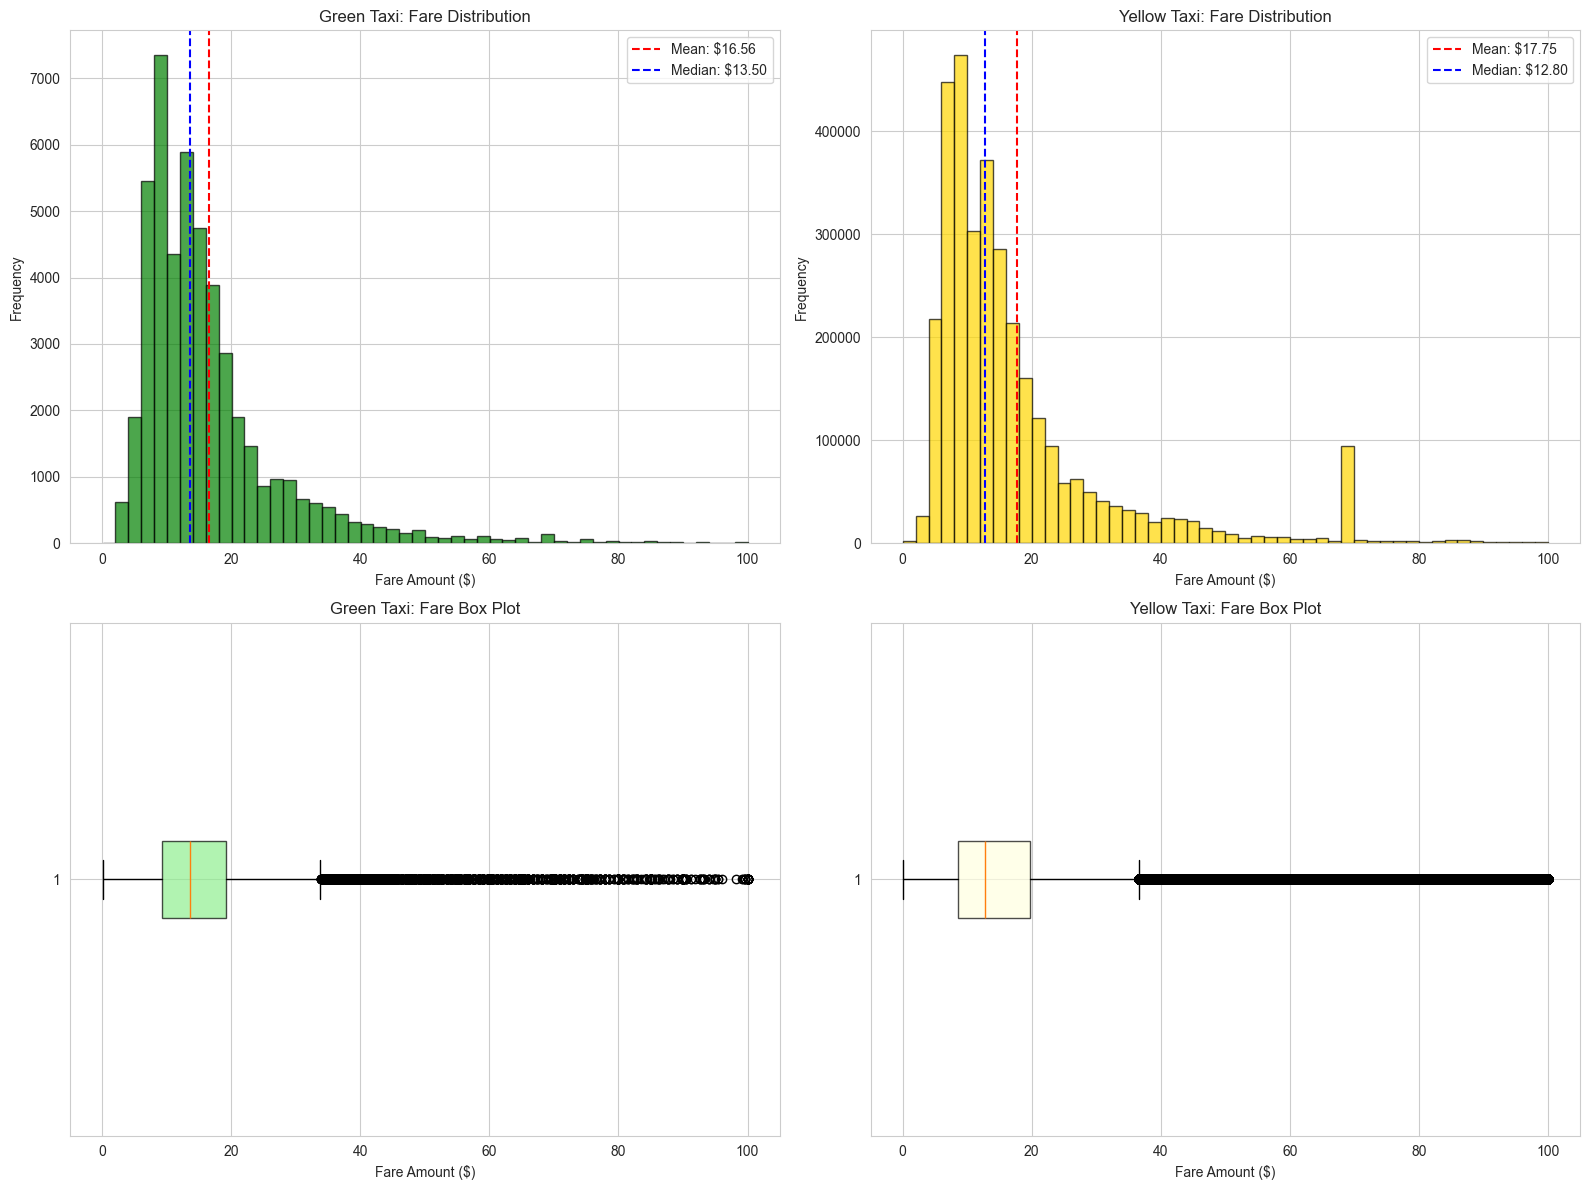

In [108]:
df1_clean = df1[(df1['fare_amount'] > 0) & (df1['fare_amount'] <= 100)]
df2_clean = df2[(df2['fare_amount'] > 0) & (df2['fare_amount'] <= 100)]

# Fare distribution histograms
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Green taxi - histogram
axes[0, 0].hist(df1_clean['fare_amount'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Fare Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Green Taxi: Fare Distribution')
axes[0, 0].axvline(df1_clean['fare_amount'].mean(), color='red', linestyle='--', label=f'Mean: ${df1_clean["fare_amount"].mean():.2f}')
axes[0, 0].axvline(df1_clean['fare_amount'].median(), color='blue', linestyle='--', label=f'Median: ${df1_clean["fare_amount"].median():.2f}')
axes[0, 0].legend()

# Yellow taxi - histogram
axes[0, 1].hist(df2_clean['fare_amount'], bins=50, color='gold', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Fare Amount ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Yellow Taxi: Fare Distribution')
axes[0, 1].axvline(df2_clean['fare_amount'].mean(), color='red', linestyle='--', label=f'Mean: ${df2_clean["fare_amount"].mean():.2f}')
axes[0, 1].axvline(df2_clean['fare_amount'].median(), color='blue', linestyle='--', label=f'Median: ${df2_clean["fare_amount"].median():.2f}')
axes[0, 1].legend()

# Green taxi - box plot
axes[1, 0].boxplot(df1_clean['fare_amount'], vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[1, 0].set_xlabel('Fare Amount ($)')
axes[1, 0].set_title('Green Taxi: Fare Box Plot')

# Yellow taxi - box plot
axes[1, 1].boxplot(df2_clean['fare_amount'], vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightyellow', alpha=0.7))
axes[1, 1].set_xlabel('Fare Amount ($)')
axes[1, 1].set_title('Yellow Taxi: Fare Box Plot')

plt.tight_layout()
plt.show()

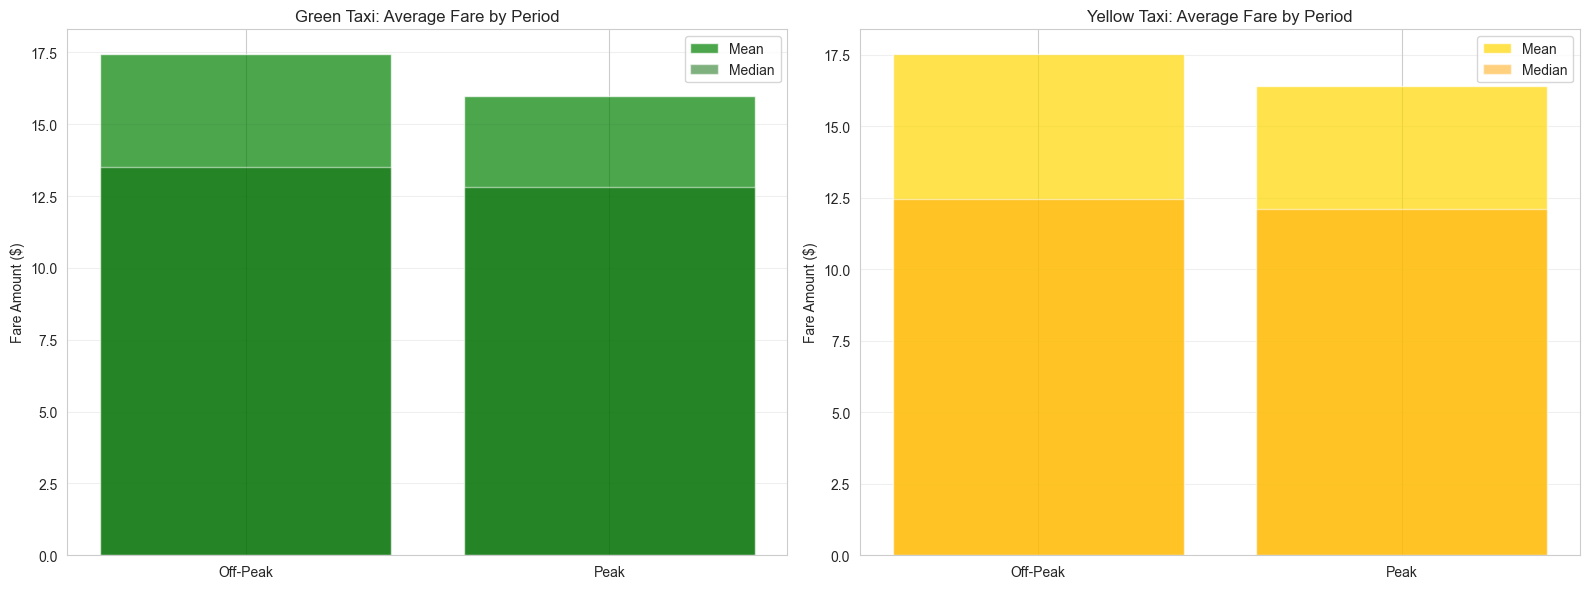

In [109]:
# Fare comparison by time period
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Green taxi
fare_by_period_green = df1_temporal.groupby('period')['fare_amount'].agg(['mean', 'median'])
axes[0].bar(fare_by_period_green.index, fare_by_period_green['mean'], alpha=0.7, color='green', label='Mean')
axes[0].bar(fare_by_period_green.index, fare_by_period_green['median'], alpha=0.5, color='darkgreen', label='Median')
axes[0].set_ylabel('Fare Amount ($)')
axes[0].set_title('Green Taxi: Average Fare by Period')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Yellow taxi
fare_by_period_yellow = df2_temporal.groupby('period')['fare_amount'].agg(['mean', 'median'])
axes[1].bar(fare_by_period_yellow.index, fare_by_period_yellow['mean'], alpha=0.7, color='gold', label='Mean')
axes[1].bar(fare_by_period_yellow.index, fare_by_period_yellow['median'], alpha=0.5, color='orange', label='Median')
axes[1].set_ylabel('Fare Amount ($)')
axes[1].set_title('Yellow Taxi: Average Fare by Period')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()